Notebook objective: Train, tune & test LightGBM model, target encoding the country variable & using year as a numeric variable.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import optuna

from category_encoders.target_encoder import TargetEncoder
#from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import GroupKFold
from lightgbm import LGBMRegressor, early_stopping

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# Set print options
np.set_printoptions(suppress=True, precision=6, edgeitems = 7)
pd.options.display.float_format = '{:.6f}'.format
pd.set_option('display.max_columns', None)

## Preprocessing

In [3]:
random_state = 1923

In [4]:
# Read data
df = pd.read_csv("./OutputData/training_data.csv")

In [5]:
# Split features and target
X = df.drop(["life_expectancy"], axis = 1)
y = df.life_expectancy

In [6]:
# Randomly select 25 countries for the testing set
rng = np.random.default_rng(random_state)
test_countries = rng.choice(X.country, size = 25)
test_countries

array(['Guyana', 'Serbia', 'Turkmenistan', 'Samoa', 'Poland',
       'Sao Tome and Principe', 'Latvia', 'Solomon Islands', 'Bhutan',
       'Armenia', 'Mauritania', 'Mozambique', 'Malawi',
       'Dominican Republic', 'Uganda', 'Madagascar', 'Sweden',
       'Central African Republic', 'Zimbabwe', 'Mongolia', 'El Salvador',
       'Argentina', 'Comoros', 'Israel', 'Angola'], dtype=object)

In [7]:
# Split train-test
X_test = X[X["country"].isin(test_countries)]
y_test = y[X_test.index]

X = X[~X["country"].isin(test_countries)]
y = y[X.index]
X = X.reset_index(drop = True)
y = y.reset_index(drop = True)

In [8]:
# Create CV splitter
cv = GroupKFold(n_splits = 3)

In [9]:
# Create target encoder
encoder = TargetEncoder(cols = "country")

## Hyperparameter tuning

In [22]:
# Objective function
def objective_lgbm(trial):

    # Define hyperparameter space
    learning_rate = trial.suggest_float("learning_rate", 0.05, 0.5)
    num_leaves = trial.suggest_int("num_leaves", 2**2, 2**10)
    min_child_samples = trial.suggest_int("min_child_samples", 10, 1000, log = True)
    min_child_weight = trial.suggest_int("min_child_weight", 0.001, 20)
    reg_alpha = trial.suggest_float("l1_reg", 5e-5, 1, log = True)
    reg_lambda = trial.suggest_float("l2_reg", 0, 2)
    subsample = trial.suggest_float("subsample", 0.5, 1)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.25, 1)

    # Store tuning scores & number of rounds
    scores = []
    rounds = []

    for i, (train_index, val_index) in enumerate(cv.split(X = X, groups = X["country"])):

        # Split train - val
        X_train, y_train = X.iloc[train_index, ], y[train_index]
        X_val, y_val = X.iloc[val_index, ], y[val_index]

        # Perform target encoding
        X_train = encoder.fit_transform(X_train, y_train)
        X_val = encoder.transform(X_val)
    
        # Create model
        if i == 0:
            callbacks = [
                optuna.integration.LightGBMPruningCallback(trial, "l2"),
                early_stopping(50, verbose = False, min_delta = 0.01) # min_delta chosen as %0.1 of first validation score
            ]
        else:
            callbacks = [
                early_stopping(50, verbose = False, min_delta = 0.01) # min_delta chosen as %0.1 of first validation score
            ]
    
        model = LGBMRegressor(
            boosting_type = "gbdt",
            num_threads = 10,
            device_type = "gpu",
            random_state = random_state,
            n_estimators = 5000,
            verbosity = -1,
            learning_rate = learning_rate,
            num_leaves = num_leaves,
            min_child_samples = min_child_samples,
            min_child_weight = min_child_weight,
            reg_alpha = reg_alpha,
            reg_lambda = reg_lambda,
            subsample = subsample,
            subsample_freq = 1,
            colsample_bytree = colsample_bytree
        )

        # Train model with early stopping
        model.fit(
            X_train, 
            y_train, 
            eval_set = [(X_val, y_val)],
            callbacks = callbacks)

        # Record best number of rounds
        rounds.append(model.best_iteration_)

        # Record best score
        scores.append(model.best_score_['valid_0']['l2'])

    # Report mean number of rounds
    trial.set_user_attr("n_rounds", (np.mean(rounds)))
    
    return np.mean(scores)


In [23]:
# Create study
study_lgbm = optuna.create_study(
  sampler = optuna.samplers.TPESampler(seed = random_state),
  pruner = optuna.pruners.HyperbandPruner(),
  study_name = "tune_lgbm",
  direction = "minimize"
)

In [24]:
# Perform study
optuna.logging.set_verbosity(optuna.logging.ERROR)
study_lgbm.optimize(
  objective_lgbm, 
  n_trials = 500,
  show_progress_bar = True)

Best trial: 105. Best value: 17.4392: 100%|██████████████████████████████████████████| 500/500 [01:30<00:00,  5.55it/s]


In [25]:
# Save tuning log
trials_lgbm = study_lgbm.trials_dataframe().sort_values("value", ascending = True)
trials_lgbm.to_csv("./OutputData/trials_lgbm.csv", index = False)

## Testing & diagnosis

In [26]:
# Load best 5 tunes
best_tunes = pd.read_csv("./OutputData/trials_lgbm.csv")
best_tunes = best_tunes[best_tunes["state"] == "COMPLETE"].iloc[0:5]
best_tune = best_tunes.iloc[0]

In [27]:
best_tunes

,number,value,datetime_start,datetime_complete,duration,params_colsample_bytree,params_l1_reg,params_l2_reg,params_learning_rate,params_min_child_samples,params_min_child_weight,params_num_leaves,params_subsample,user_attrs_n_rounds,system_attrs_completed_rung_0,system_attrs_completed_rung_1,system_attrs_completed_rung_2,system_attrs_completed_rung_3,system_attrs_completed_rung_4,state
0,105,17.439156,2023-12-12 10:16:52.184198,2023-12-12 10:16:52.891481,0 days 00:00:00.707283,0.356327,0.000062,1.082886,0.089449,55,7,799,0.820870,65.000000,23.470711,21.029404,NaN,NaN,NaN,COMPLETE
1,23,18.609887,2023-12-12 10:16:32.665760,2023-12-12 10:16:33.376258,0 days 00:00:00.710498,0.255438,0.000150,1.113010,0.083999,36,1,600,0.632412,80.000000,53.206923,39.841216,24.054512,21.323898,NaN,COMPLETE
2,4,18.872237,2023-12-12 10:16:25.065807,2023-12-12 10:16:27.303044,0 days 00:00:02.237237,0.308917,0.057225,0.382776,0.158853,10,6,455,0.954141,75.333333,57.629553,41.034115,28.236191,21.450427,21.148559,COMPLETE
3,86,18.954426,2023-12-12 10:16:46.042680,2023-12-12 10:16:48.002500,0 days 00:00:01.959820,0.307580,0.000274,0.395031,0.159294,10,7,431,0.753714,43.000000,40.230206,27.811336,21.058382,20.779648,NaN,COMPLETE
4,49,19.186394,2023-12-12 10:16:38.723193,2023-12-12 10:16:39.945795,0 days 00:00:01.222602,0.280038,0.000164,1.357888,0.131272,20,4,748,0.757846,56.000000,31.582373,21.387223,20.378343,NaN,NaN,COMPLETE


In [28]:
# Preprocess data for final model
X_train = encoder.fit_transform(X, y)
X_test = encoder.transform(X_test)
y_train = y.copy()

In [29]:
# Train final model
model = LGBMRegressor(
        boosting_type = "gbdt",
        random_state = random_state,
        subsample_freq = 1,
        verbosity = -1,
        importance_type = "gain",
        n_estimators = int(best_tune["user_attrs_n_rounds"]),
        learning_rate = best_tune["params_learning_rate"],
        num_leaves = best_tune["params_num_leaves"],
        min_child_samples = best_tune["params_min_child_samples"],
        min_child_weight = best_tune["params_min_child_weight"],
        reg_alpha = best_tune["params_l1_reg"],
        reg_lambda = best_tune["params_l2_reg"],
        subsample = best_tune["params_subsample"],
        colsample_bytree = best_tune["params_colsample_bytree"])

model.fit(X_train, y_train)

Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  File "C:\Users\PC\Documents\WorkLocal\DataScience\GitHub\PanelLifeExpectancy\venv\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


LGBMRegressor(colsample_bytree=0.3563270393949909, importance_type='gain',
              learning_rate=0.0894491597291881, min_child_samples=55,
              min_child_weight=7, n_estimators=65, num_leaves=799,
              random_state=1923, reg_alpha=6.164528873689802e-05,
              reg_lambda=1.0828859319796451, subsample=0.8208695593301554,
              subsample_freq=1, verbosity=-1)

In [30]:
# Make predictions on test data
preds = model.predict(X_test)

In [31]:
# Calculate MSE, RMSE, MAPE
print("MSE:")
print(round(mean_squared_error(y_test, preds), 4))

print("RMSE:")
print(round(mean_squared_error(y_test, preds, squared = False), 4))

print("MAPE:")
print(round(mean_absolute_percentage_error(y_test, preds), 4))

MSE:
20.7198
RMSE:
4.5519
MAPE:
0.0585


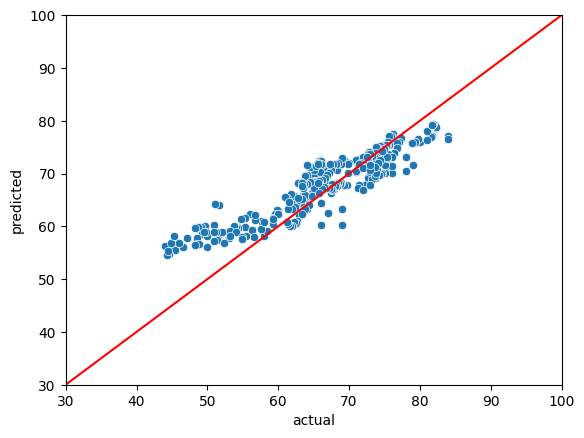

In [32]:
# Plot predicted vs. actual
_ = sns.scatterplot(x = y_test,  y = preds)
_ = plt.plot([30, 100], [30, 100], c = "red")
_ = plt.xlim(30, 100)
_ = plt.ylim(30, 100)
_ = plt.xlabel("actual")
_ = plt.ylabel("predicted")

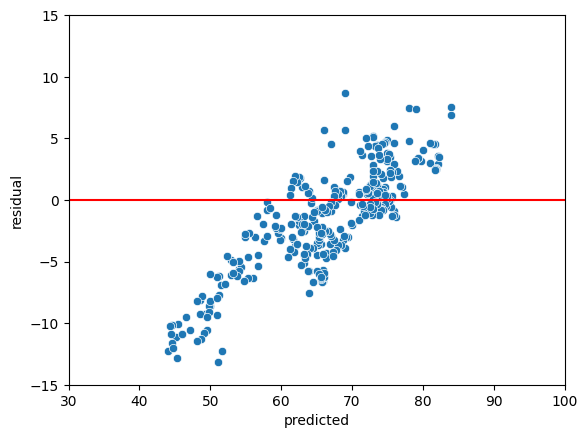

In [39]:
# Predicted vs residual
resids = y_test - preds
_ = sns.scatterplot(x = y_test, y= resids)
_ = plt.plot([30, 100], [0, 0], c = "red")
_ = plt.xlim(30, 100)
_ = plt.ylim(-15, 15)
_ = plt.xlabel("predicted")
_ = plt.ylabel("residual")

Some countries are considerably overpredicted. Likely due to country-specific factors that are missed out on training with this testing scheme.

In [62]:
# Particularly overpredicted countries
overpredictions = resids[resids <= -7.5]
df.iloc[df.index.isin(overpredictions.index)].country.unique()

array(['Angola', 'Central African Republic', 'Malawi', 'Mongolia',
       'Mozambique', 'Uganda', 'Zimbabwe'], dtype=object)

## Inference

In [40]:
# Get SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_train)

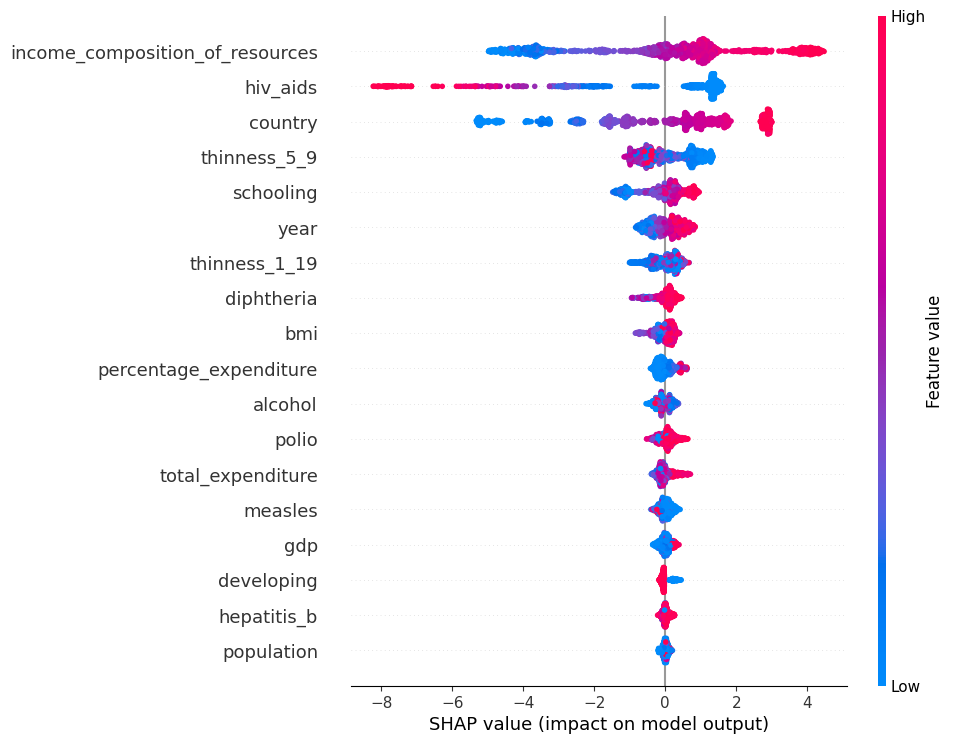

In [41]:
# SHAP summary of all features
shap.plots.beeswarm(shap_values, max_display = 20)

Country loses its dominance as a predictor with the leave-groups-out testing scheme. It's still one of the three most significant.

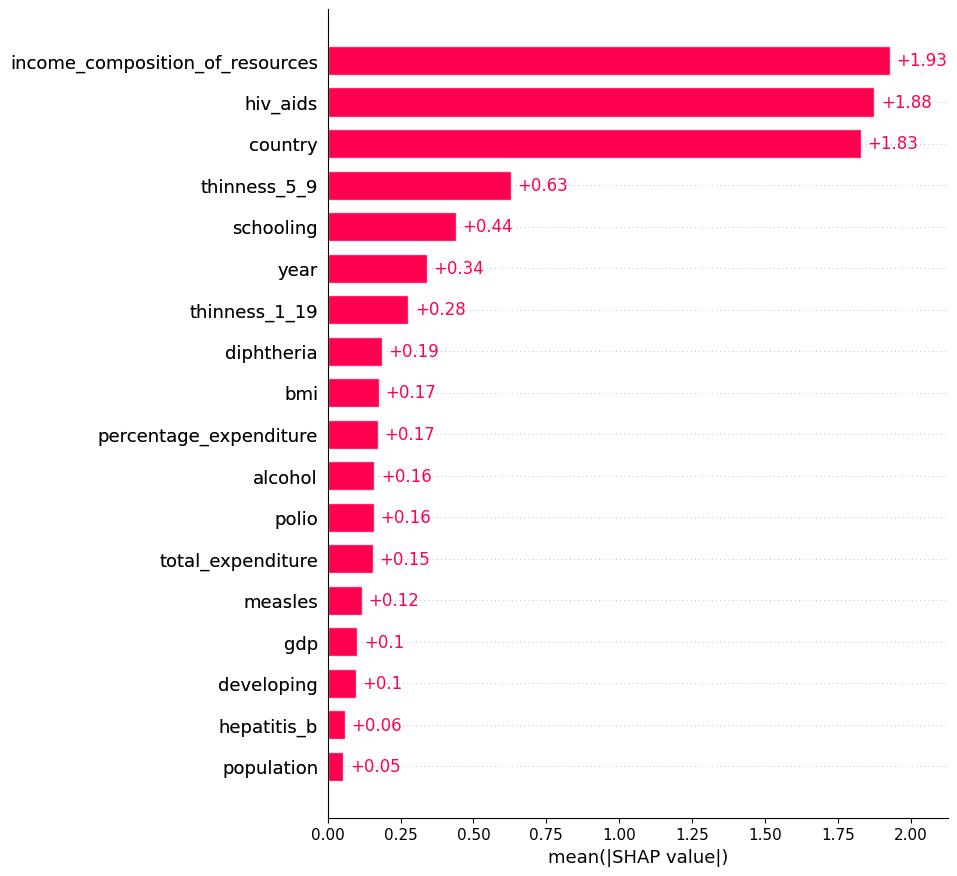

In [42]:
shap.plots.bar(shap_values, max_display = 20)